# Lab 3

## Question 1

## Question 2

ICML is a top research conference in Machine learning.  Scrape all the pdfs of all ICML 2017 papers from http://proceedings.mlr.press/v70/.

In [121]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
import wget


def collect_pdfs():
    base_url = 'http://proceedings.mlr.press/v70/'
    html = urlopen(base_url).read()
    html_page = bs(html) 
    
    collected = []
    
    for link in html_page.find_all('a'):
        if link.get('href').endswith('pdf') and not link.get('href').endswith('-supp.pdf'):
            try:
                filename = './pdfs/' + link.get('href').split('/')[-1]
                wget.download(link.get('href'), out=filename)
                collected.append(filename)
            except:
                print('Could not download ', link.get('href'))
    
    return collected

In [122]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def pdf_to_text(filename):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    
    with open(filename, 'rb') as pdf:
        for page in PDFPage.get_pages(pdf):
            interpreter.process_page(page)

    text = retstr.getvalue()
    device.close()
    retstr.close()
    return text

In [123]:
files = collect_pdfs()

In [ ]:
# write out all the pdf content into a text file
# avoids having to do this multiple times
    
for pdf in files:
    filename = "./converted_pdfs/" + pdf.split('/')[-1].split('.')[0] + ".txt"
    with open(filename, 'w') as txt_file:
        text = pdf_to_text(pdf)
        txt_file.write(text)

1. What are the top 10 common words in the ICML papers?

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

vectorizer = CountVectorizer()
training_words = None

with open('training_words.txt', 'r') as train:
    training_words = train.read()

c = Counter([x.lower() for x in training_words.split()])

In [70]:
counts = {k:v for k, v in sorted(c.items(), key=lambda x: x[1], reverse=True) if k.isalpha() and len(k) > 1}

In [71]:
top10 = dict(sorted(counts.items(), key=lambda x: x[1], reverse = True)[:10])
print(top10)

{'the': 205147, 'of': 101886, 'and': 87289, 'in': 68292, 'to': 64706, 'is': 55298, 'for': 51197, 'we': 50972, 'that': 36466, 'with': 29882}


2.  Let Z be a randomly selected word in a randomly selected ICML paper.  Estimate the entropy of Z.

In [72]:
import numpy as np

total_observed = sum(v for _,v in counts.items())
entropy = 0
for _, obs in counts.items():
    entropy += (obs/total_observed) * np.log2(obs/total_observed)
entropy = -entropy
print(entropy)

9.708366314011496


3.  Synthesize a random paragraph using the marginal distribution over words.

In [75]:
probabilities = []
for word, obs in counts.items():
    probabilities.extend([word] * obs)
print(len(probabilities))

for i in range(100):
    num = np.random.uniform(0, total_observed)
    print(probabilities[int(num)])

2643672
in
local
zhang
using
jl
two
et
sales
here
the
take
and
is
multiscale
of
for
number
decision
was
are
et
bringing
royal
ranges
to
the
is
of
tried
journal
formal
cab
according
with
guaranteed
from
he
can
as
and
course
literature
axis
with
the
the
is
structured
to
all
exercise
powerful
miny
evaluations
chosen
the
maximization
intervention
set
factorization
our
in
iteration
and
the
we
changing
result
variational
in
and
using
on
is
and
fourth
an
across
the
decision
assumed
using
due
baselines
statement
be
rectangular
spirit
on
in
to
the
of
saga
it
the
introduction
using
clamping
to


## Question 3

here


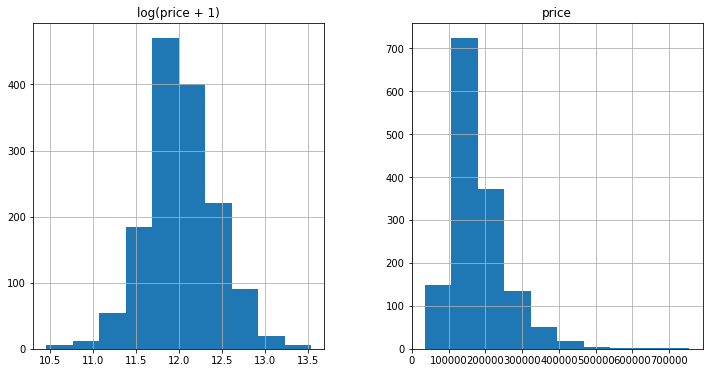

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%matplotlib inline
train = pd.read_csv('./kaggle/train.csv')
test = pd.read_csv('./kaggle/test.csv')

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

print('here')

In [8]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [9]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [10]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [11]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [12]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y)

results = np.expm1(model_ridge.predict(X_test))
results_df = pd.DataFrame(results)
results_df.columns = ['SalePrice']

results_df.index += 1461
results_df.index.name = 'Id'

results_df.to_csv('./kaggle/results.csv')

Simple Ridge submission results:

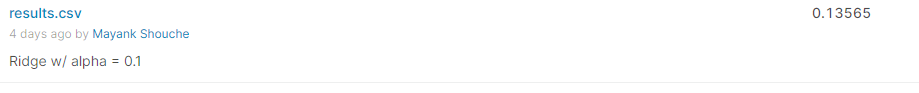

Compare a ridge regression and a lasso regression model.  
Optimize the alphas using crossvalidation.  
What is the best score you can get from a single ridge regression model and froma single lasso model?

Text(0, 0.5, 'rmse')

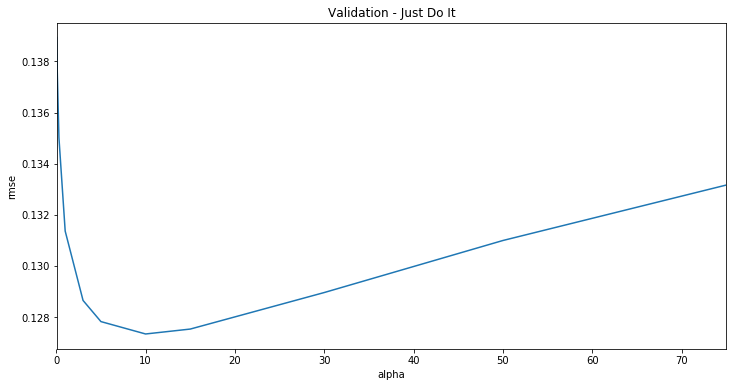

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    # gets the rmse using cross validation as a metric
    # cross validation is a means of measuring performance
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()


alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [15]:
best_cv_ridge = cv_ridge.min()

# from the graph above, an alpha of 10 minimizes RMSE
optimal_ridge = Ridge(alpha=10)
optimal_ridge.fit(X_train, y)

results_ridge = np.expm1(optimal_ridge.predict(X_test))
results_ridge_df = pd.DataFrame(results_ridge)
results_ridge_df.columns = ['SalePrice']

results_ridge_df.index += 1461
results_ridge_df.index.name = 'Id'

results_ridge_df.to_csv('./kaggle/results_ridge.csv')


Text(0, 0.5, 'rmse')

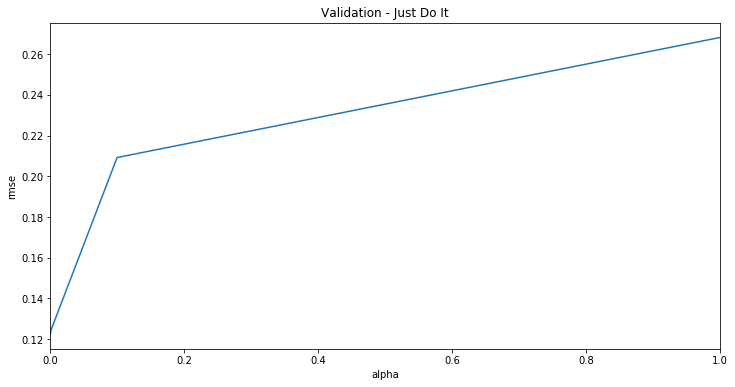

In [16]:
alph =  [1, 0.1, 0.001, 0.0005]
cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alph]
cv_lasso = pd.Series(cv_lasso, index=alph)
cv_lasso.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
best_cv_lasso = rmse_cv(model_lasso).mean()

results_lasso = np.expm1(model_lasso.predict(X_test))
results_lasso_df = pd.DataFrame(results_lasso)
results_lasso_df.columns = ['SalePrice']

results_lasso_df.index += 1461
results_lasso_df.index.name = 'Id'

results_lasso_df.to_csv('./kaggle/results_lasso.csv')


Scores from the best Ridge and Lasso models:
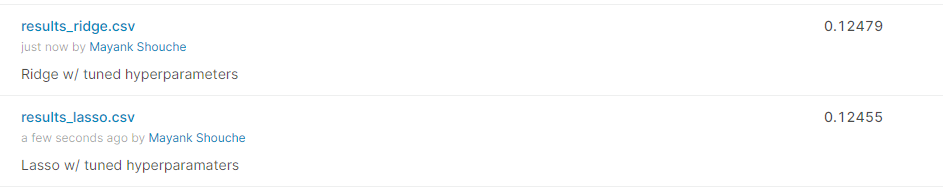

It appears that lasso gets a slightly better score than ridge.

Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary thestrength of regularization parameter alpha.

Text(0, 0.5, 'l0 Norm')

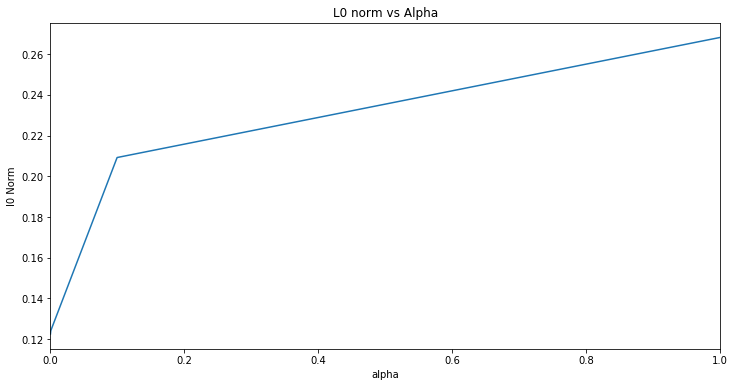

In [18]:
def number_nonzeroes(model):
    model.fit(X_train, y)
    return np.count_nonzero(model.coef_)

    

alph =  [1, 0.1, 0.001, 0.0005]
non_zeroes = [number_nonzeroes(Lasso(alpha=alpha)) for alpha in alph]
non_zeroes_lasso = pd.Series(non_zeroes, index=alph)
cv_lasso.plot(title="L0 norm vs Alpha")
plt.xlabel("alpha")
plt.ylabel("l0 Norm")

5.  Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking).  Be careful not to overfit. What score can you get?  (We will be discussing ensembling more, later in the class, but you can start playing with it now).

In [28]:
from sklearn.model_selection import KFold

models = [LassoCV(alphas=[1, 0.1, 0.001, 0.0005]), RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75])]
kf = KFold(n_splits=len(models))

# train both models on different halves of the dataset
for (train, _), model in zip(kf.split(X_train), models):
    model.fit(X_train[train[0]:train[-1]], y[train[0]:train[-1]])
    
# train the final model with a stack of the original features and model outputs
model_predictions = np.column_stack([m.predict(X_train) for m in models])
new_features = np.c_[X_train, model_predictions]

# get the best alpha for this new step in the pipeline
stacked_model = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75])
stacked_model.fit(new_features, y)

# make predictions and correctly shape output for submission
ensemble_test_preds = np.column_stack([m.predict(X_test) for m in models])
ensemble_test = np.c_[X_test, ensemble_test_preds]

results_ensembled = np.expm1(stacked_model.predict(ensemble_test))
results_ensembled_df = pd.DataFrame(results_ensembled)
results_ensembled_df.columns = ['SalePrice']

results_ensembled_df.index += 1461
results_ensembled_df.index.name = 'Id'

results_ensembled_df.to_csv('./kaggle/results_ensembled.csv')

(1459, 288)


Results from ensembling and stacking:

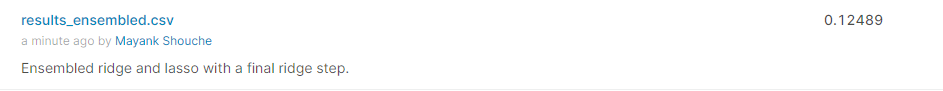

6. Install XGBoost (Gradient Boosting) and train a gradient boosting regression.  What score can you get just from a single XGB? (you will need to optimize over its parameters).  We will discuss boosting and gradient boosting in more detail later.  XGB is a great friend to all goodKagglers!

/home/sunny/fall_2020/ee460j/dslabenv/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


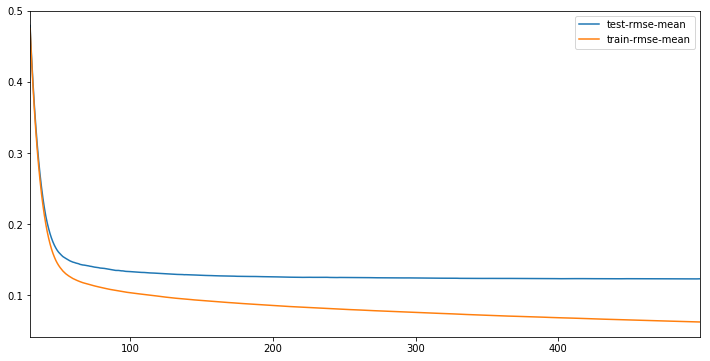

In [31]:
# ! pip3 install xgboost

import xgboost as xgb

# read in data
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()


# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)



